## Building a fully functional ANN II

In this part we add the backpropagation part to the layers.

**0) Loading and Preparing Data**

Importing libraries:

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#importing the spiral data set 
#pip install nnfs
from nnfs.datasets import spiral_data

<br>

Importing the spiral dataset (Nsamples for each class):

In [2]:
Nsample  = 300
Nclasses = 5
[X, Y]   = spiral_data(samples = Nsample, classes = Nclasses)

Plotting the dataset:

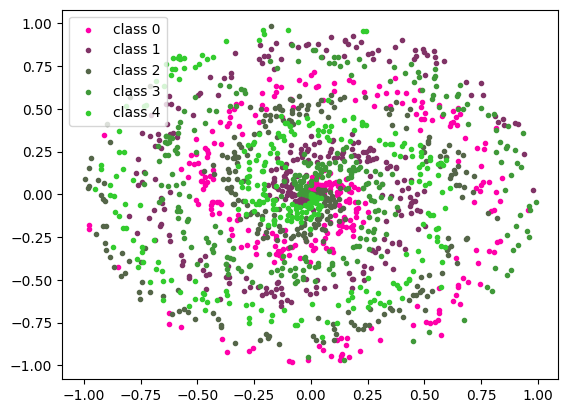

In [3]:
for n in range(Nclasses):
    idx   = np.argwhere(Y == n)[:,0]
    xplot = X[idx,0]
    yplot = X[idx,1]
    plt.scatter(xplot, yplot, marker = '.', color = [1/(n+1), n/Nclasses, 2/(2*n + 3)], label = 'class ' + str(n))
plt.legend()
plt.show()

<br>

**1) Defining all the Parts we need for an ANN**<br>
<br>
We start with defining the dense layer again, now including backpropagation:

In [7]:
class Layer_Dense():
    
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons)
        self.biases  = np.zeros((1, n_neurons))
        
    def forward(self, inputs):
        self.output  = np.dot(inputs, self.weights) + self.biases
        self.inputs  = inputs

    def backward(self, dvalues):
        #gradients
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases  = np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs  = np.dot(dvalues, self.weights.T)

and as well as for the activation layer.

In [9]:
class Activation_ReLU():
    
    def forward(self, inputs):
        self.output  = np.maximum(0, inputs)
        self.inputs  = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0#ReLU derivative

In [11]:
class Activation_Sigmoid():
        
    def forward(self, inputs):
        self.output = np.clip(1/(1 + np.exp(-inputs)), 1e-7, 1-1e-7)
        self.inputs = inputs

    def backward(self, dvalues):
        sigm         = self.output
        deriv        = np.multiply(sigm, (1 - sigm))#inner derivative of sigmoid
        self.dinputs = np.multiply(deriv, dvalues)

<br>

**2) The ANN**

In the next step, we call the different instances of the layers and stack them togehter to a *serial ANN* and add the backpropagation part in reverse order.

In [13]:
Nneurons1 = 64
Nfeatures = X.shape[1]

dense1    = Layer_Dense(Nfeatures, Nneurons1)
dense_reg = Layer_Dense(Nneurons1, 1)        #for regression: one value for each data point
dense_cla = Layer_Dense(Nneurons1, Nclasses) #for classification: Nclasses values (later: probability for each class) for each data point

In [15]:
ReLU      = Activation_ReLU()
Sigm      = Activation_Sigmoid()

<br>

The target vector is $Y$. We want to rename $Y$ in order to be consistent with our slides.

In [17]:
print(Y)
Target = Y.reshape((len(Y),1))

[0 0 0 ... 4 4 4]


In the next step, we run the *forward* part as before and then compare the predicted output $Ypred$ to the target output. This leads to the outermost derivative, the change of the loss function which is $E = \frac{1}{2}(Ypred - Target)^2$ here, hence the derivative is $dE = (Ypred - Target)$.<br>
The derivative $dE$ is then fed into the *backward* part of the last layer. Within this layer, two things will happen:<br> 
- 1) $dE$ will be multiplied with the inner derivative of the layer and this product is the new outer derivative when being passed on to the next layer and so on
- 2) if this layer has learnables (weights and biases), the changes $dw$ and $db$ will be calculated too.

In [57]:
alpha = 0.001

#forward part:
dense1.forward(X)
ReLU.forward(dense1.output)
dense_reg.forward(ReLU.output)

#comparing target to output
Ypred = dense_reg.output
dE    = Ypred - Target #outermost derivative

MSE   = np.sum(abs(dE))/(Nsample*Nclasses)
print('MSE = ' + str(MSE))

#backward part:
dense_reg.backward(dE)
ReLU.backward(dense_reg.dinputs)
dense1.backward(ReLU.dinputs)

#finally, we apply gradient descent
dense_reg.weights -= alpha * dense_reg.dweights 
dense_reg.biases  -= alpha * dense_reg.dbiases

dense1.weights    -= alpha * dense1.dweights 
dense1.biases     -= alpha * dense1.dbiases

MSE = 1.2015350264808133


Run the above cell repeatedly. The MSE might increase in the first steps, but should go down after a few iterations. Try the same with different activation functions and learning rates.